<a href="https://colab.research.google.com/github/tanujn45/Twitter-IO/blob/main/SP_Text_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps for easy understanding

1.   Import all modules
2.   Retrieve all tweetIds from csv file
3.   Load EAST model
4.   Core function
    *   Retrieve image from the tweetId
    *   Prepare the Image for EAST model
    *   Pass through EAST and determine if there is text
    *   If text present pass through Tesserract
    *   File the text in a txt file and store it locally
     







In [ ]:
!jupyter contrib nbextension install --user
!jupyter nbextension enable hinterland/hinterland

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console execute kernel kernelspec
migrate nbconvert nbextension notebook qtconsole run serverextension
troubleshoot trust

Jupyter command `jupyter-contrib` not found.
Enabling notebook extension hinterland/hinterland...
Paths used for configurat

In [ ]:
# Step 1: Importing all modules
import cv2
print(cv2.__version__)

4.1.2


In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import time
import pytesseract
import PIL
import pandas as pd
import tweepy as tw
from skimage import io
from matplotlib import pyplot as plt

In [ ]:
# Step 2: Retrieve all tweetIds from csv file
df = pd.read_csv('/content/tweetID.csv')
tweetIds = df['tweet_id'].to_list()

In [ ]:
#Step 3: Loading EAST model and helper functions
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

min_confidence = 0.8

def ocr_core(img):
  text = pytesseract.image_to_string(img)
  return text

img = cv2.imread('imgpath')

def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image):
  return cv2.medianBlur(image, 5)

def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def round32(x):
  return (x+16) & ~31

def ShowBoxes(boxes, rW, rH, orig):
	for (startX, startY, endX, endY) in boxes:
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)
	plt.imshow(orig)

args = {
#         'image' : './images/sign.jpg',
#         'image' : './images/car_wash.png',
#         'image' : './images/lebron_james.jpg',
        'image' : './images/Screenshot from 2018-10-28 19-29-11.png',
        'east' : '/content/frozen_east_text_detection.pb',
        'min_confidence' : min_confidence,
}

print("loading EAST text detector...")
net = cv2.dnn.readNet(args['east'])

loading EAST text detector...


In [ ]:
# Step 4: Core function
def ImageToText(ImageUrl):
  image = io.imread(ImageUrl)
  plt.imshow(image)
  orig = image.copy()

  (H, W) = image.shape[:2]

  tesseractOutputImage = np.zeros_like(orig)
  (newW, newH) = (round32(W), round32(H))

  rW = W / float(newW)
  rH = H / float(newH)

  image = cv2.resize(image, (round32(W), round32(H)))
  (H, W) = image.shape[:2]

  # plt.imshow(image, interpolation = 'nearest')
  # plt.show()
  # plt.imshow(orig)
  # plt.show()

  # blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	# (123.68, 116.78, 103.94), swapRB=True, crop=False)
  # start = time.time()
  # net.setInput(blob)
  # print('test')
  # (scores, geometry) = net.forward(layerNames)
  # end = time.time()
  # print('test')
  # # print("[INFO] text detection took {:.6f} seconds".format(end - start))
  # (numRows, numCols) = scores.shape[2:4]
  # rects = []
  # confidences = []
  # print('test')
  # for y in range(0, numRows):
  #   scoresData = scores[0, 0, y]
  #   xData0 = geometry[0, 0, y]
  #   xData1 = geometry[0, 1, y]
  #   xData2 = geometry[0, 2, y]
  #   xData3 = geometry[0, 3, y]
  #   anglesData = geometry[0, 4, y]

  #   for x in range(0, numCols):
  #     if scoresData[x] < min_confidence:
  #       continue
  #     (offsetX, offsetY) = (x * 4.0, y * 4.0)

  #     angle = anglesData[x]
  #     cos = np.cos(angle)
  #     sin = np.sin(angle)

  #     h = xData0[x] + xData2[x]
  #     w = xData1[x] + xData3[x]

  #     endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
  #     endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
  #     startX = int(endX - w)
  #     startY = int(endY - h)

  #     rects.append((startX, startY, endX, endY))
  #     confidences.append(scoresData[x])

  # # print(confidences)
  # # print(rects)

  # boxes = non_max_suppression(np.array(rects), probs=confidences)
  boxes = [1]
  if len(boxes) != 0:
    img = orig
    #img = get_grayscale(img)
    #img = thresholding(img)
    #img = remove_noise(img)
    plt.imshow(img)
    print('text')
    print(ocr_core(img))
    # origTesseract = orig.copy()
    # for (startX, startY, endX, endY) in boxes:
    #     startX = int(startX * rW)
    #     startY = int(startY * rH)
    #     endX = int(endX * rW)
    #     endY = int(endY * rH)

    #     extraPixelsX = 0.99
    #     extraPixelsY = 0.90
    #     croppedImage = origTesseract[int(startY * extraPixelsY):int(endY / extraPixelsY), int(startX * extraPixelsX):int(endX / extraPixelsX)]
    #     config = ('-l eng --oem 3 --psm 6')
    #     text = pytesseract.image_to_string(croppedImage, config = config).encode('utf-8')
    #     print(startX, startY, endX, endY)
    #     textScale = int((2.0 * (endX - startX) / 200.0) / (len(text)+0.002)*5)
    #     textThickness = int(max(4*(endX-startX)/200/(len(text)+1)*4, 0))
    #     print("Text Scale: ", textScale)
    #     print("Text Thickness: ", textThickness)
    #     cv2.putText(tesseractOutputImage, str(text), (startX, endY), cv2.FONT_HERSHEY_SIMPLEX, textScale, (0, 255, 0), textThickness, lineType = cv2.LINE_AA)
    #     plt.imshow(croppedImage)
    #     plt.show()
    #     print("Text:", str(text))

    # plt.imshow(tesseractOutputImage)
    # plt.show()
    # cv2.imwrite("tesseract Detection-"+str(min_confidence)+"-"+str(width)+"-"+str(height)+".jpg", tesseractOutputImage)

    # for (startX, startY, endX, endY) in boxes:

    #     startX = int(startX * rW)
    #     startY = int(startY * rH)
    #     endX = int(endX * rW)
    #     endY = int(endY * rH)

    # cv2.imwrite("Text Detection-"+str(min_confidence)+"-"+str(width)+"-"+str(height)+".jpg", orig)


text
 

Text Message
Today 3:19 PM

Hi, this is Rob from Domino's
(the App State store). You
applied to work here before...
would you be willing to talk
with a manager about working

lal=c-m nena

Cte aera



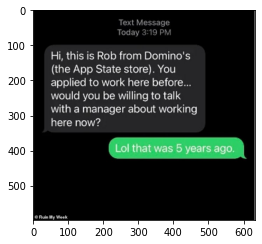

In [ ]:
tweetUrls = [
          'https://i.dailymail.co.uk/1s/2021/04/09/15/41546552-9454069-Waste_of_time_One_person_was_left_in_hysterics_after_suddenly_re-a-18_1617979357813.jpg'
]


for tweetUrl in tweetUrls:
  ImageToText(tweetUrl)